# PROJETO 3 - VAE

- Selecionar 2 datasets (rotulados)

- Treinar modelos VAEs:

-  Ajustar o melhor modelo (topologia) segundo a função
de custo (conjunto validação)

- Explorar o espaço latente:

-  Gerar gráficos com a projeção do espaço latente em 2D
(PCA)

- Usar os rótulos na projeção

## Algumas questões:

1. Há formação de clusters no espaço latente?

2. Há separação dos rótulos no espaço latente?

3. A projeção ilustra quanto da variância?

# sobre os auto encoders 

- A ideia que gera em torno nos autoencoders é a ideia de minimizar. No qual temos que minimizar a informação de tal forma a poder gerar algo a partir disso ou seja eu vou minimizar e conseguir reconstruir depois dessa forma podemos assumir que a informação de entrada era esparsa o bastante para poder ser comprimida sem perder informação e dessa forma podemos a partir de clusterização identificar o que é o que. 


- A ideia básica é a seguinte: Você consegue reproduzir uma informação mesmo que seja com um certo grau de erro 

- O que é necessário para o auto encoder sào três coisas uma função de encoder uma de decorder e um a de distância entre as perdas ocorridas durante a transformação da imagem normalmente essas funções de encoder e decoder normalmente são paramétricas aqui entra a ideia do gradeiente descedente estocástico que entra para ser uma função para auxiliar na reconstrução minimizando a função de perdas  

- o espaço latente é esse espaço reduzido que faz parte da correlação entre encoder e decoder 



# Primeiro dataset

Como eu sou da área de estudo da terra focado em queimada eu irei enviar a seguinte imagem que representaem uma área queimada e em outra vegetação

# Minha área 

é uma área que teve uma queimada e minha entrada é o dndvi mas ele está fora do intervalo e eu normalizei minha imagem para existir somente entre -1 e 1 então vou recortar essa imagem então reamostrada fica como sendo a abaixo

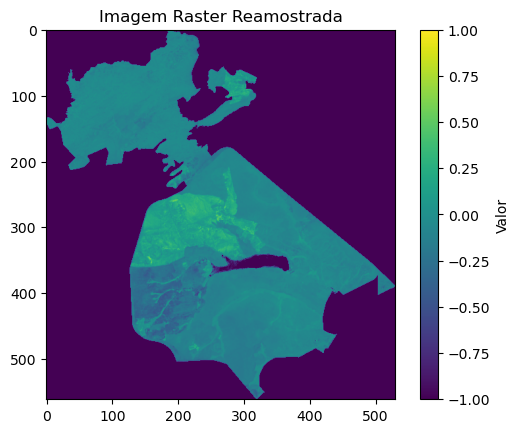

In [15]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Passo 1: Carregar o Raster Original
with rasterio.open('area_2019_dndvi.tif') as src:
    raster_data = src.read(1)  # Lê a primeira banda

# Passo 2: Reamostrar o Raster
# Suponha que você queira reduzir o tamanho da imagem pela metade
# A escala de reamostragem deve ser calculada conforme necessário
scale_factor = 0.5  # Exemplo de fator de escala para reamostragem

# Reamostrar os dados usando scipy.ndimage.zoom
reamostrado_data = zoom(raster_data, scale_factor, order=1)  # order=1 é a interpolação bilinear

# Passo 3: Visualizar a Imagem Reamostrada
# Limitar os valores ao intervalo -1 a 1 (opcional)
reamostrado_data = np.clip(reamostrado_data, -1, 1)

# Criar a visualização
plt.imshow(reamostrado_data, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Valor')
plt.title('Imagem Raster Reamostrada')
plt.show()


Agora transformando essa imagem e alterando para int 64 que tem resolução radiométrica de 8 bits 

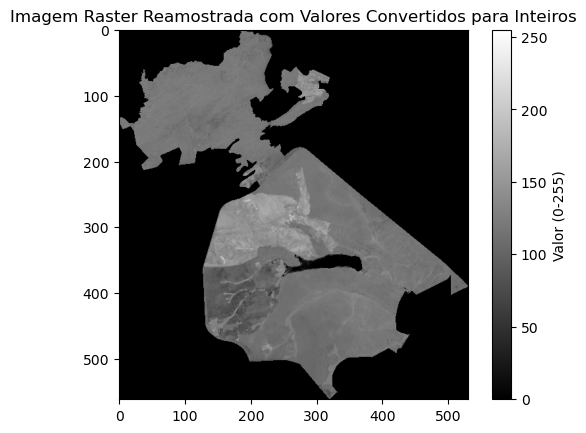

16


(562, 530)

In [26]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Passo 1: Carregar o Raster Original
with rasterio.open('area_2019_dndvi.tif') as src:
    raster_data = src.read(1)  # Lê a primeira banda

# Passo 2: Reamostrar o Raster
scale_factor = 0.5  # Exemplo de fator de escala para reamostragem
reamostrado_data = zoom(raster_data, scale_factor, order=1)  # order=1 é a interpolação bilinear

# Passo 3: Limitar os valores ao intervalo -1 a 1
reamostrado_data = np.clip(reamostrado_data, -1, 1)

# Passo 4: Normalizar os Valores para o Intervalo 0 a 255
# Normalizando para o intervalo [0, 255]
norm_data = (reamostrado_data + 1) / 2 * 255
# Converter para inteiros
int_data = norm_data.astype(np.int64)

# Passo 5: Visualizar a Imagem Reamostrada
plt.imshow(int_data, cmap='gray', vmin=0, vmax=255)
plt.colorbar(label='Valor (0-255)')
plt.title('Imagem Raster Reamostrada com Valores Convertidos para Inteiros')
plt.show()
print(int(min(int_data.shape[0]/32,int_data.shape[1]/32)))
int_data.shape

# Subdivisão da imagem 
nesse sentido para poder trabalhar com janelas de 32x32 eu poderei fazer 16x16 separações da imagem pois cabem ao menos 16x16 janelas de 32x32 nessa minha imagem e disso vamos poder testar o autoencoder

In [31]:
import cv2
import numpy as np
import os

# Carregar a imagem
image = int_data

# Dimensões da janela
window_size = 32
img_height, img_width = image.shape[:2]

# Diretório para salvar as janelas
output_dir = 'windows'

# Criar o diretório se não existir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lista para armazenar as janelas
windows = []

for y in range(0, img_height, window_size):
    for x in range(0, img_width, window_size):
        # Verifique se a janela está dentro dos limites da imagem
        window = image[y:y + window_size, x:x + window_size]
        # Se a janela for menor que o tamanho especificado (nas bordas da imagem), preencha com preto
        if window.shape[0] < window_size or window.shape[1] < window_size:
            padded_window = np.zeros((window_size, window_size, 3), dtype=np.uint8)
            padded_window[:window.shape[0], :window.shape[1],0] = window
            windows.append(padded_window)
        else:
            windows.append(window)

# Salvar as janelas na pasta 'windows'
for i, window in enumerate(windows):
    file_path = os.path.join(output_dir, f'window_{i}.png')
    cv2.imwrite(file_path, window)

print(f'Janelas salvas na pasta "{output_dir}"')


Janelas salvas na pasta "windows"


# Removendo as amostras que são iguais a zero

In [ ]:
import cv2
import numpy as np
import os

# Diretório que contém as janelas
output_dir = 'windows'

# Função para calcular a soma dos valores dos pixels de uma imagem
def pixel_sum(image_path):
    # Carregar a imagem
    image = cv2.imread(image_path)
    # Converter para escala de cinza para simplificar a soma dos pixels
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calcular a soma dos valores dos pixels
    return np.sum(gray_image)

# Percorrer todos os arquivos na pasta 'windows'
for file_name in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file_name)
    if os.path.isfile(file_path):
        # Calcular a soma dos pixels
        if pixel_sum(file_path) < 10:
            # Remover o arquivo se a soma dos pixels for menor que 10
            os.remove(file_path)
            print(f'Removido: {file_path}')

print('Limpeza concluída.')


# Preparação dos Dados

In [44]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

# Função para carregar e normalizar imagens
def load_images_from_folder(folder, image_size=(32, 32)):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)  # Redimensionar se necessário
            img = img.astype('float32') / 255.0  # Normalizar para o intervalo [0, 1]
            images.append(img)
    return np.array(images)

# Carregar o dataset de janelas
images_windows = load_images_from_folder('windows')

# Dividir em conjuntos de treinamento e validação
X_train, X_val = train_test_split(images_windows, test_size=0.2, random_state=42)


# Construção e Treinamento do VAE

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (32, 32, 3)
latent_dim = 2

def build_encoder(latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim + latent_dim)(x)  # Mean and log variance
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    return models.Model(inputs, [z_mean, z_log_var], name='encoder')

# Construir o decoder
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((8, 8, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, outputs, name='decoder')

# Função para amostragem
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Construir o VAE
def build_vae(latent_dim):
    encoder = build_encoder(latent_dim)
    decoder = build_decoder(latent_dim)
    
    inputs = layers.Input(shape=input_shape)
    z_mean, z_log_var = encoder(inputs)
    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    outputs = decoder(z)
    
    vae = models.Model(inputs, outputs, name='vae')

    # Função de perda
    reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= np.prod(input_shape)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae, encoder, decoder

vae, encoder, decoder = build_vae(latent_dim)

# Treinar o modelo VAE
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = vae.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val), callbacks=[early_stopping])


2024-09-01 01:18:29.003243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-01 01:18:29.005311: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
2/2 [==============================] - 1s 209ms/step - loss: 2124.1611 - val_loss: 2115.6729
Epoch 2/50
2/2 [==============================] - 0s 54ms/step - loss: 2095.2903 - val_loss: 2088.0801
Epoch 3/50
2/2 [==============================] - 0s 54ms/step - loss: 2050.4121 - val_loss: 2061.1475
Epoch 4/50
2/2 [==============================] - 0s 56ms/step - loss: 2005.6420 - val_loss: 2075.7400
Epoch 5/50
2/2 [==============================] - 0s 51ms/step - loss: 1984.0006 - val_loss: 2086.8948
Epoch 6/50
2/2 [==============================] - 0s 57ms/step - loss: 1931.7847 - val_loss: 2100.2339
Epoch 7/50
2/2 [==============================] - 0s 57ms/step - loss: 1939.0757 - val_loss: 2115.6326
Epoch 8/50
2/2 [==============================] - 0s 54ms/step - loss: 1916.9077 - val_loss: 2029.6462
Epoch 9/50
2/2 [==============================] - 0s 54ms/step - loss: 1911.3218 - val_loss: 2068.7415
Epoch 10/50
2/2 [==============================] - 0s 50ms/step - loss: 

# Exploração do Espaço Latente

1/1 [==============================] - 0s 63ms/step


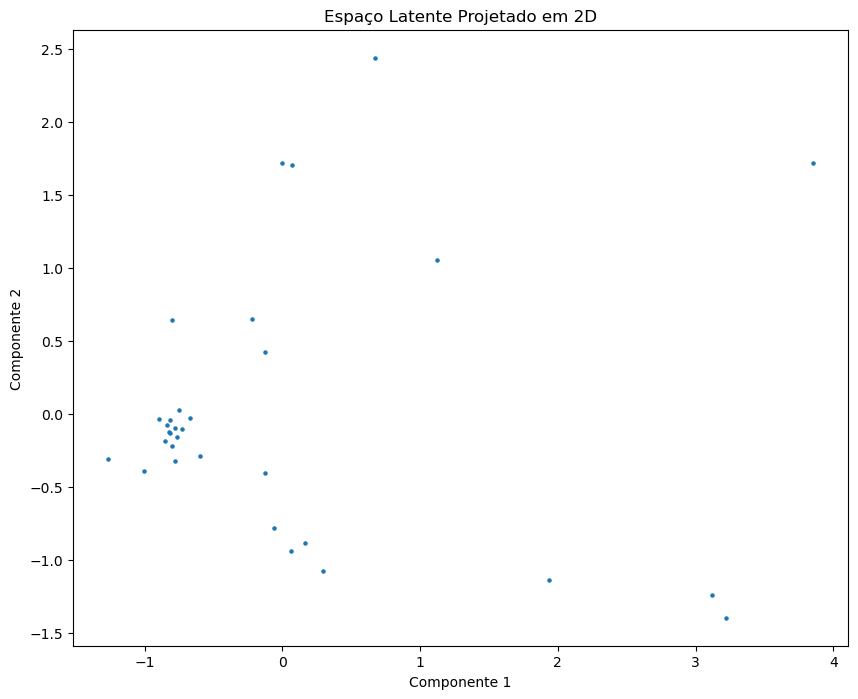

Variância explicada pelos componentes principais: 1.0


In [46]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Codificar as imagens para obter o espaço latente
z_mean, _ = encoder.predict(X_val)

# Reduzir a dimensionalidade do espaço latente para 2D
pca = PCA(n_components=2)
z_mean_2d = pca.fit_transform(z_mean)

# Plotar o espaço latente
plt.figure(figsize=(10, 8))
plt.scatter(z_mean_2d[:, 0], z_mean_2d[:, 1], s=5)
plt.title('Espaço Latente Projetado em 2D')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

# Variância explicada
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f'Variância explicada pelos componentes principais: {explained_variance}')


# Ajustando a arquitetura da VAE

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import binary_crossentropy


input_shape = (32, 32, 3) 
latent_dim = 2


def build_encoder(latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim + latent_dim)(x) 
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    return models.Model(inputs, [z_mean, z_log_var], name='encoder')

# Construir o decoder
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(4 * 4 * 128, activation='relu')(latent_inputs)
    x = layers.Reshape((4, 4, 128))(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, outputs, name='decoder')


def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def build_vae(latent_dim):
    encoder = build_encoder(latent_dim)
    decoder = build_decoder(latent_dim)
    
    inputs = layers.Input(shape=input_shape)
    z_mean, z_log_var = encoder(inputs)
    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    outputs = decoder(z)
    
    vae = models.Model(inputs, outputs, name='vae')

    # Função de perda
    reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= np.prod(input_shape)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae, encoder, decoder

vae, encoder, decoder = build_vae(latent_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = vae.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val), callbacks=[early_stopping])


Epoch 1/50
2/2 [==============================] - 1s 193ms/step - loss: 2109.0488 - val_loss: 2140.2952
Epoch 2/50
2/2 [==============================] - 0s 62ms/step - loss: 2035.8547 - val_loss: 2065.8975
Epoch 3/50
2/2 [==============================] - 0s 61ms/step - loss: 1970.5508 - val_loss: 2070.1526
Epoch 4/50
2/2 [==============================] - 0s 62ms/step - loss: 1943.4304 - val_loss: 2081.8948
Epoch 5/50
2/2 [==============================] - 0s 60ms/step - loss: 1918.4576 - val_loss: 2074.0857
Epoch 6/50
2/2 [==============================] - 0s 68ms/step - loss: 1911.5002 - val_loss: 2099.5657
Epoch 7/50
2/2 [==============================] - 0s 62ms/step - loss: 1893.2457 - val_loss: 2039.0024
Epoch 8/50
2/2 [==============================] - 0s 63ms/step - loss: 1865.3298 - val_loss: 2048.6477
Epoch 9/50
2/2 [==============================] - 0s 63ms/step - loss: 1809.6038 - val_loss: 2010.6494
Epoch 10/50
2/2 [==============================] - 0s 59ms/step - loss: 

# Ajuste da Função de Perda

In [48]:

def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= np.prod(input_shape)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

vae.compile(optimizer='adam', loss=lambda x, y: vae_loss(x, y, z_mean, z_log_var))


# Visualizando o codigo 

2024-09-01 01:33:32.028173: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-01 01:33:32.070182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-01 01:33:32.387493: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-01 01:33:32.389880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 01:33:33.236055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Epoch 1/100
2/2 [==============================] - 1s 222ms/step - loss: 2120.9551 - val_loss: 2098.9780
Epoch 2/100
2/2 [==============================] - 0s 63ms/step - loss: 2052.7534 - val_loss: 2069.5376
Epoch 3/100
2/2 [==============================] - 0s 64ms/step - loss: 1992.3545 - val_loss: 2189.2266
Epoch 4/100
2/2 [==============================] - 0s 64ms/step - loss: 1990.7532 - val_loss: 2094.0942
Epoch 5/100
2/2 [==============================] - 0s 64ms/step - loss: 1970.1097 - val_loss: 2056.5083
Epoch 6/100
2/2 [==============================] - 0s 61ms/step - loss: 1952.4963 - val_loss: 2063.1609
Epoch 7/100
2/2 [==============================] - 0s 59ms/step - loss: 1948.1157 - val_loss: 2080.9521
Epoch 8/100
2/2 [==============================] - 0s 62ms/step - loss: 1944.9368 - val_loss: 2084.9939
Epoch 9/100
2/2 [==============================] - 0s 61ms/step - loss: 1912.7661 - val_loss: 2051.0815
Epoch 10/100
2/2 [==============================] - 0s 63ms/ste

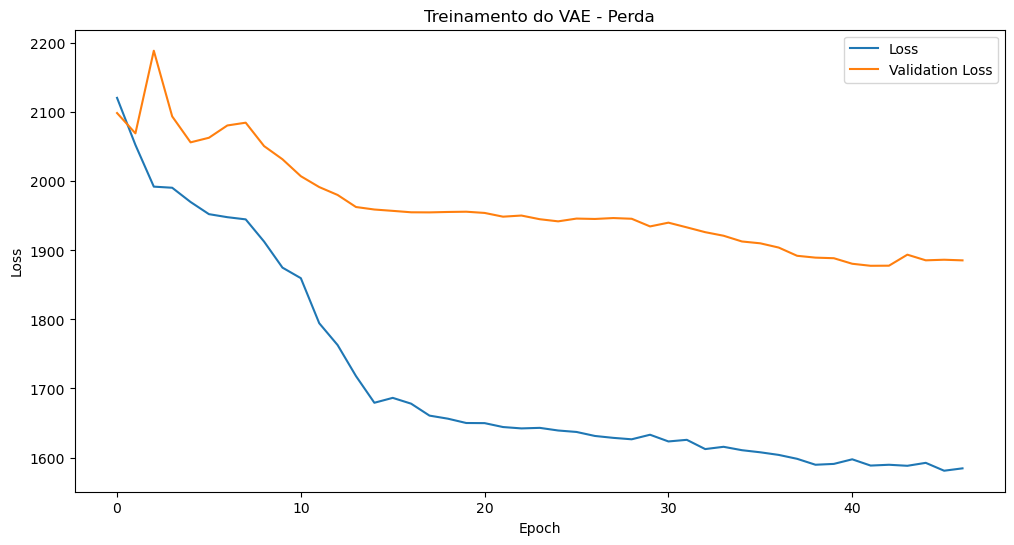

1/1 [==============================] - 0s 128ms/step


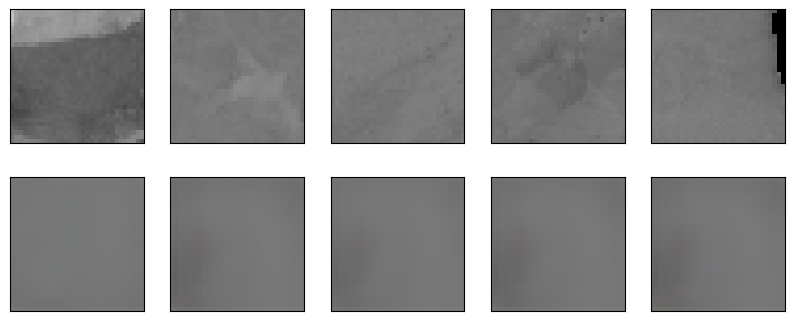

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def load_images_from_folder(folder, image_size=(32, 32)):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)  
            img = img.astype('float32') / 255.0 
            images.append(img)
    return np.array(images)

images_windows = load_images_from_folder('windows')

X_train, X_val = train_test_split(images_windows, test_size=0.2, random_state=42)

input_shape = (32, 32, 3)
latent_dim = 2

#%%%%%%%%%%%%%%Encoder#%%%%%%%%%%%%%%
def build_encoder(latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim + latent_dim)(x) 
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    return models.Model(inputs, [z_mean, z_log_var], name='encoder')


#%%%%%%%%%%%%%%Decoder#%%%%%%%%%%%%%%
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(4 * 4 * 128, activation='relu')(latent_inputs)
    x = layers.Reshape((4, 4, 128))(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, outputs, name='decoder')


def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(latent_dim):
    encoder = build_encoder(latent_dim)
    decoder = build_decoder(latent_dim)
    
    inputs = layers.Input(shape=input_shape)
    z_mean, z_log_var = encoder(inputs)
    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    outputs = decoder(z)
    
    vae = models.Model(inputs, outputs, name='vae')

    reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= np.prod(input_shape)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae, encoder, decoder

vae, encoder, decoder = build_vae(latent_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = vae.fit(X_train, X_train, epochs=100, batch_size=64, validation_data=(X_val, X_val), callbacks=[early_stopping])

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Treinamento do VAE - Perda')
plt.show()

def show_images(original, reconstructed):
    n = min(5, original.shape[0])
    plt.figure(figsize=(10, 4))
    
    for i in range(n):
        
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
       
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

reconstructed_images = vae.predict(X_val)

show_images(X_val, reconstructed_images)


# Conclusão 

A ideia de haver uma overfiting parece clara principalmente depois de visualizar o resultado final pois o resultado da validaçào está descolando do resultado das perdas 